In [258]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from random import sample
from sklearn import model_selection
from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

1. Реализация одного или нескольких из критериев останова в дереве решений (количество листьев, количество используемых признаков, глубина дерева и т.д.).

2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

## Создание тестовых данных

In [239]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples = 1000,
    n_features = 15, n_informative = 15, 
    n_classes = 2, n_redundant=0, 
    n_clusters_per_class=1,
    random_state=42)

In [240]:
classification_data.shape

(1000, 15)

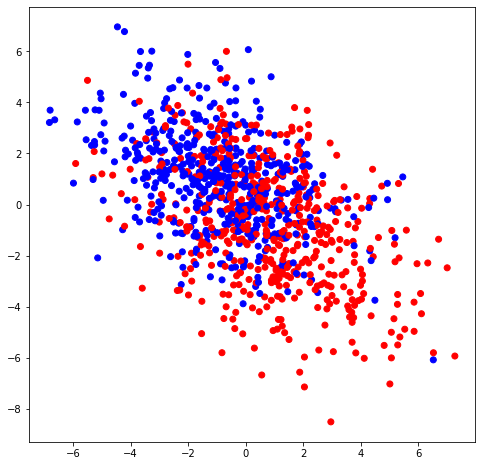

In [241]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

## Cоздание алгоритма дерева

In [154]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [155]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [156]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

__Добавлен критерий энтропии__

In [157]:
# Расчет критерия энтропии Шеннона

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

__Изменена функция критерия качества для выбора критерия (Джинни или Энтропия)__

In [158]:
# Расчет качества

def quality(left_labels, right_labels, current_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    share_left = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    # доля выборки, ушедшая в правое поддерево
    share_right = 1 - share_left
    
    return current_criterion - share_left * criterion(left_labels) - (share_right) * criterion(right_labels)

In [159]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

__Добавлено ограничение по колучеству признаков в дереве__

In [160]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf, max_features, criterion):

    current_criterion = criterion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    if n_features > max_features:
        n_features = max_features
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [189]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf=5, max_features=10, criterion=gini):

    quality, t, index = find_best_split(data, labels, min_leaf, max_features, criterion)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf, max_features, criterion)
    false_branch = build_tree(false_data, false_labels, min_leaf, max_features, criterion)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [162]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [163]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [246]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [247]:
# Построим дерево по обучающей выборке
my_tree_gini = build_tree(train_data, train_labels)
my_tree_entropy = build_tree(train_data, train_labels, criterion=entropy)

In [166]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [248]:
print_tree(my_tree_gini)

Индекс 9
Порог 1.9150203438056455
--> True:
  Индекс 0
  Порог 0.5622071316153281
  --> True:
    Индекс 8
    Порог 1.3291474134798569
    --> True:
      Индекс 4
      Порог -1.4014749196936296
      --> True:
        Индекс 9
        Порог -0.3742563291646046
        --> True:
          Индекс 5
          Порог -2.2156731716984135
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Индекс 1
        Порог -2.8480139530122113
        --> True:
          Прогноз: 0
        --> False:
          Индекс 2
          Порог -4.514039930833877
          --> True:
            Прогноз: 1
          --> False:
            Индекс 8
            Порог 0.8645453408347614
            --> True:
              Индекс 5
              Порог -2.967038188202931
              --> True:
                Прогноз: 1
              --> False:
                Индекс 1
                Порог -1.3527858835568174
       

In [249]:
print_tree(my_tree_entropy)

Индекс 9
Порог 2.0856001134074007
--> True:
  Индекс 0
  Порог 0.5622071316153281
  --> True:
    Индекс 9
    Порог 0.1858121600412206
    --> True:
      Индекс 2
      Порог -3.6633842710073012
      --> True:
        Индекс 3
        Порог 0.9988999923581245
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Индекс 8
        Порог 1.36636424415099
        --> True:
          Индекс 1
          Порог -2.4194612177965977
          --> True:
            Прогноз: 1
          --> False:
            Прогноз: 1
        --> False:
          Индекс 0
          Порог -0.3247799716059131
          --> True:
            Прогноз: 1
          --> False:
            Индекс 6
            Порог 1.7238427604647968
            --> True:
              Прогноз: 0
            --> False:
              Прогноз: 1
    --> False:
      Индекс 4
      Порог -0.22435373291845717
      --> True:
        Индекс 8
        Порог -1.620456257783764
        --> T

In [244]:
# Функция подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [250]:
# Получим ответы для обучающей и тестовой выборки 
train_answers = predict(train_data, my_tree_entropy)
test_answers = predict(test_data, my_tree_entropy)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(96.0, 90.0)

In [251]:
train_answers = predict(train_data, my_tree_gini)
test_answers = predict(test_data, my_tree_gini)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
train_accuracy, test_accuracy

(94.71428571428572, 88.0)

На больших данных критерий энтропии даёт более точные результаты.